# Import necessary libraries

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import pytz
from IPython.display import VimeoVideo
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

#Load dataset

In [10]:
df = pd.read_csv("/content/drive/MyDrive/september_2018_sensor_data_archive.csv")
df.head()

,timestamp,P2
0,2018-09-01 00:00:26.722,19.30
1,2018-09-01 00:00:43.434,16.90
2,2018-09-01 00:01:19.344,16.10
3,2018-09-01 00:01:26.343,10.83
4,2018-09-01 00:01:29.906,18.47


# Prepare Data

In [11]:
# Convert the "timestamp" column to a DatetimeIndex
df["timestamp"] = pd.to_datetime(df["timestamp"], infer_datetime_format=True)
df.set_index("timestamp", inplace=True)

In [8]:
df.index

Index(['2018-09-01 00:00:26.722', '2018-09-01 00:00:43.434',
       '2018-09-01 00:01:19.344', '2018-09-01 00:01:26.343',
       '2018-09-01 00:01:29.906', '2018-09-01 00:01:55.249',
       '2018-09-01 00:01:58.020', '2018-09-01 00:02:31.149',
       '2018-09-01 00:02:56.864', '2018-09-01 00:03:07.001',
       ...
       '2018-09-30 23:50:47.248', '2018-09-30 23:52:45.173',
       '2018-09-30 23:52:47.873', '2018-09-30 23:53:15.733',
       '2018-09-30 23:55:15.116', '2018-09-30 23:55:19.018',
       '2018-09-30 23:55:44.216', '2018-09-30 23:57:44.955',
       '2018-09-30 23:57:49.369', '2018-09-30 23:58:12.719'],
      dtype='object', name='timestamp', length=60718)

All the timestamps are in UTC so I need to Localize a timestamp in the Africa/Nairobi time zone.

In [12]:
# Localize timezone
df.index = df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")

# Display the first five rows of the DataFrame
print(df.head())

                                     P2
timestamp                              
2018-09-01 03:00:26.722000+03:00  19.30
2018-09-01 03:00:43.434000+03:00  16.90
2018-09-01 03:01:19.344000+03:00  16.10
2018-09-01 03:01:26.343000+03:00  10.83
2018-09-01 03:01:29.906000+03:00  18.47


#Explore

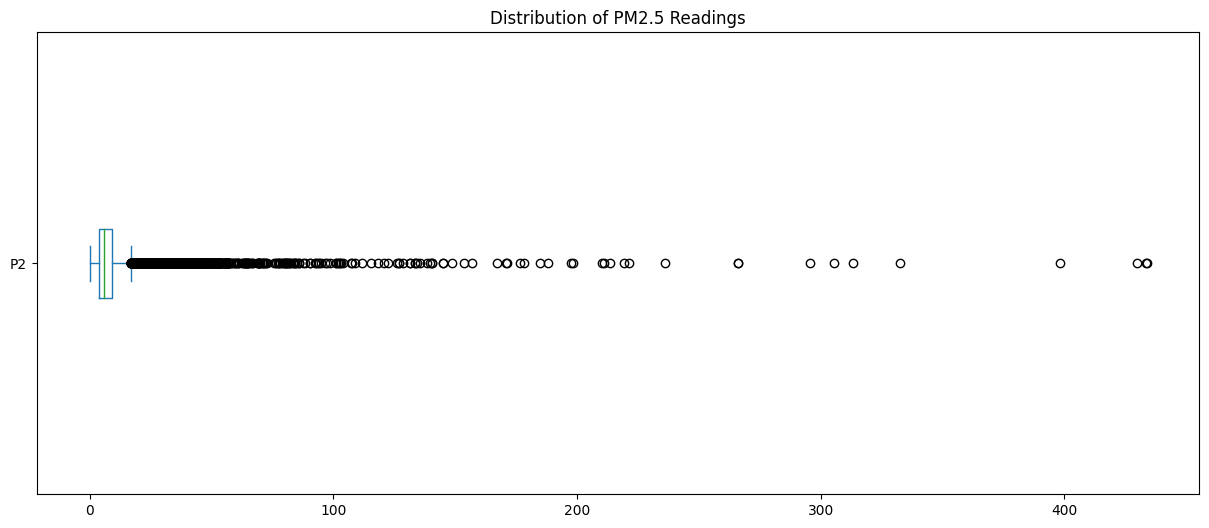

In [13]:
# Create a boxplot of the "P2" readings
fig, ax = plt.subplots(figsize=(15, 6))
df["P2"].plot(kind="box",vert=False,title="Distribution of PM2.5 Readings",ax=ax);

There are PM 2.5  readings at 700 , I don't think that is even possible to get an air quality reading that high.
I will guess that is some sort of error because from the Bliss Air website the maximum level of pm2.5 at 500 so I will remove the readings above 500.

In [14]:
#Remove outliers
df=df[df["P2"]<500]

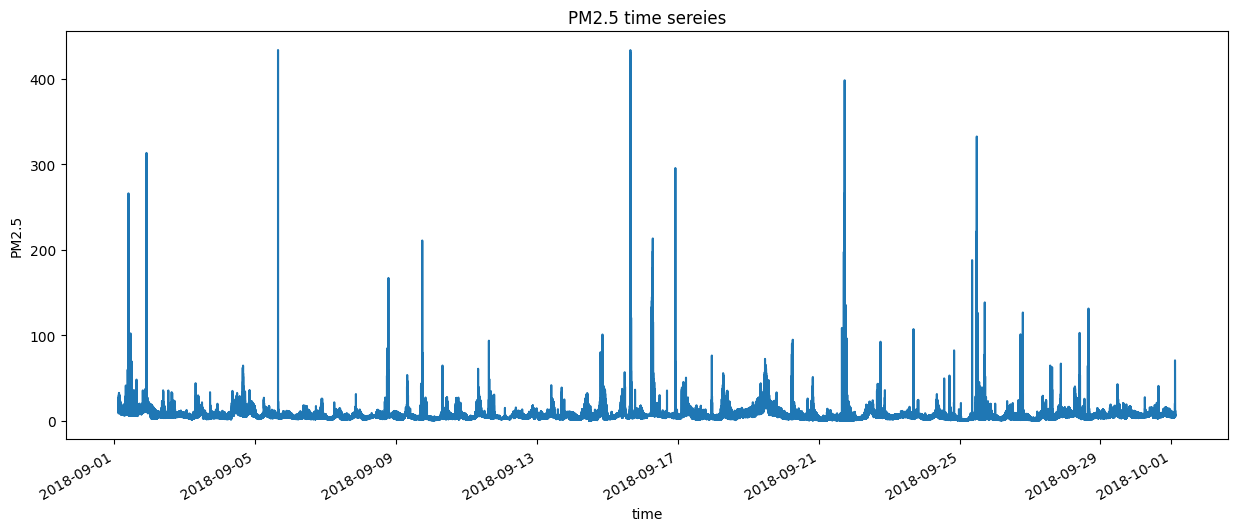

In [15]:
#Create a time series plot of the "P2" readings in df.
fig, ax = plt.subplots(figsize=(15, 6))
df["P2"].plot(xlabel="time",ylabel="PM2.5",title="PM2.5 time sereies",ax=ax);


 Notice here That the P2 readings are measeured every 5 minutes but I  actually  want it to be every hour

In [16]:
# Resample to 1H window,ffil missing values
df = df["P2"].resample("1H").mean().fillna(method="ffill").to_frame()

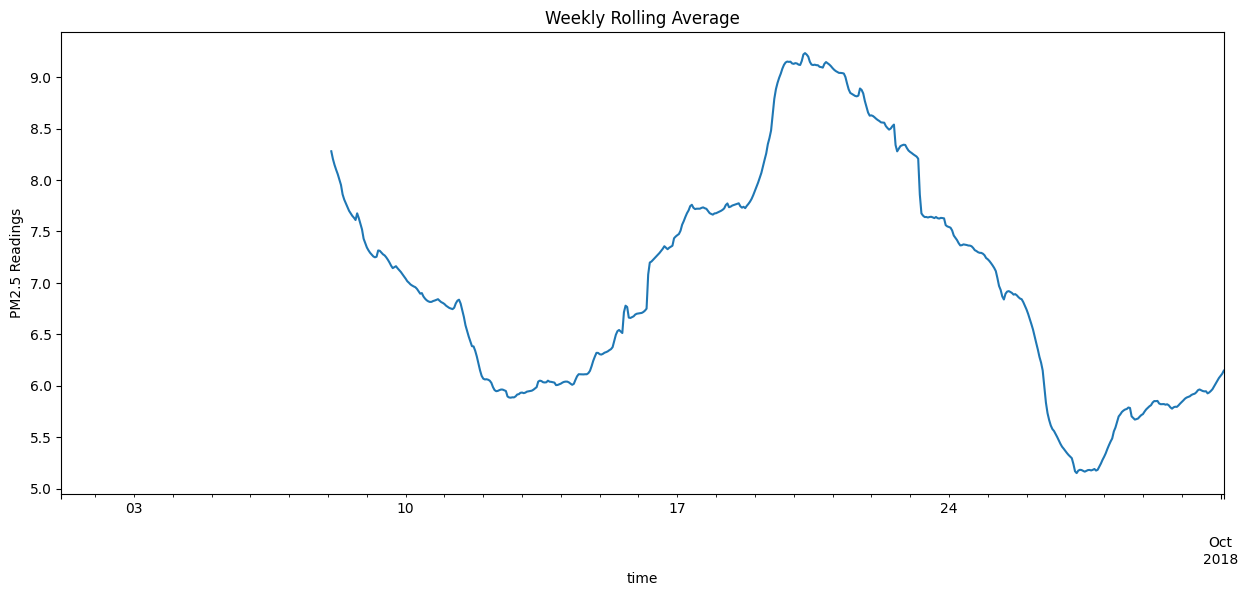

In [17]:
# Plot the rolling average of the "P2" readings
fig, ax = plt.subplots(figsize=(15, 6))
df["P2"].rolling(168).mean().plot(ax=ax,xlabel="time",ylabel="PM2.5 Readings",title="Weekly Rolling Average");

In [18]:
# Add lag feature
df["P2.L1"]=df["P2"].shift(1)

In [31]:
df.dropna(inplace=True)

In [32]:
#Create a correlation matrix
df.corr()

,P2,P2.L1
P2,1.000000,0.658274
P2.L1,0.658274,1.000000


There is a fairly strong correlation between value and its lag

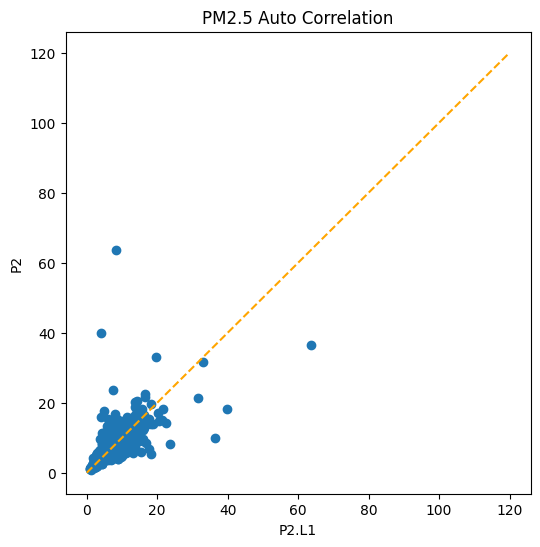

In [33]:
#Create a scatter plot that shows PM 2.5 mean reading for each our as a function of the mean reading from the previous hour.
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=df["P2.L1"],y= df["P2"])
ax.plot([0,120],[0,120],linestyle="--",color="orange")
plt.xlabel("P2.L1")
plt.ylabel("P2")
plt.title("PM2.5 Auto Correlation");

#Split

In [34]:
#Split the DataFrame df into the feature matrix X and the target vector y
target = "P2"
y = df[target]
X = df.drop(columns=target)

In [35]:
y.head()

timestamp
2018-09-01 04:00:00+03:00    13.275321
2018-09-01 05:00:00+03:00    11.583333
2018-09-01 06:00:00+03:00    11.627500
2018-09-01 07:00:00+03:00    13.981279
2018-09-01 08:00:00+03:00    14.213542
Freq: H, Name: P2, dtype: float64

In [36]:
X.head()

,P2.L1
timestamp,
2018-09-01 04:00:00+03:00,15.858454
2018-09-01 05:00:00+03:00,13.275321
2018-09-01 06:00:00+03:00,11.583333
2018-09-01 07:00:00+03:00,11.627500
2018-09-01 08:00:00+03:00,13.981279


In [37]:
#Split X and y into training and test sets.
#The first 80% of the data should be in your training set. The remaining 20% should be in the test set.
cutoff = int(len(X)*0.8)

X_train, y_train = X.iloc[:cutoff],y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:],y.iloc[cutoff:]
len(X_train)+len(X_test)== len(X)

True

#Build Model
calculate the baseline mean absolute error for your model.


In [38]:
# Predict using baseline model
# Baseline model predicts the same value for all inputs,
# which is the mean of the target variable in the training set.
y_pred_baseline = len(y_train) * [y_train.mean()]

# Calculate mean absolute error (MAE) for the baseline model
# MAE measures the absolute difference between the true values and the predicted values.
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

# Print the mean value of the target variable in the training set
print("Mean P2 Reading:", round(y_train.mean(), 2))

# Print the MAE of the baseline model
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 7.48
Baseline MAE: 3.19


#Iterate

In [39]:
#Instantiate a LinearRegression model named model, and fit it to the training data.
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

#Evaluate

In [40]:
# Calculate mean absolute error (MAE) for the training set
# MAE measures the absolute difference between the true values and the predicted values for the training set.
training_mae = mean_absolute_error(y_train, model.predict(X_train))

# Calculate mean absolute error (MAE) for the test set
# MAE measures the absolute difference between the true values and the predicted values for the test set.
test_mae = mean_absolute_error(y_test, model.predict(X_test))

# Print the MAE for the training set, rounded to two decimal places.
print("Training MAE:", round(training_mae, 2))

# Print the MAE for the test set, rounded to two decimal places.
print("Test MAE:", round(test_mae, 2))

Training MAE: 1.91
Test MAE: 1.44


#Communicate Results

In [41]:
# Extract the intercept and coefficient from the model.
intercept = model.intercept_.round(2)
coefficient = model.coef_.round(2)[0]

print(f"P2 = {intercept} + ({coefficient} * P2.L1)")

P2 = 2.62 + (0.65 * P2.L1)


In [42]:
# Create a DataFrame df_pred_test that has two columns: "y_test" and "y_pred"
df_pred_test = pd.DataFrame(
{"y_test":y_test,
 "y_pred":model.predict(X_test)
}
)
df_pred_test.head()

,y_test,y_pred
timestamp,,
2018-09-25 03:00:00+03:00,0.970689,3.188810
2018-09-25 04:00:00+03:00,1.024941,3.247114
2018-09-25 05:00:00+03:00,1.401455,3.282253
2018-09-25 06:00:00+03:00,2.147898,3.526125
2018-09-25 07:00:00+03:00,3.371041,4.009602


In [43]:
#Create a time series line plot for the values in test_predictions using plotly express. 
fig = px.line(df_pred_test,labels={"value":"P2"})
fig.show()